## Contents:
* [Loading packages](#Loading_packages)
* [Reading cell2location model output](#read)


* [Running factorisation to identify groups of co-located cell types / tissue compartments](#factorisation)
* [Running factorisation including the composition of neighbouring spots](#factorisation_with_neighbours)

### Loading packages <a class="anchor" id="Loading_packages"></a>

In [1]:
# Import modules and packages:
%pylab inline
import pandas as pd
import sys, ast, os
rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False
import pickle as pickle
import numpy as np
import time
import itertools
data_type = 'float32'

#os.environ["THEANO_FLAGS"] = 'device=cuda,floatX=' + data_type + ',force_device=True'
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/cell2location/')
sys.path.insert(1, '/nfs/team205/vk7/sanger_projects/BayraktarLab/cell2location/')

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import os
import cell2location.models as c2l
import anndata
import scanpy as sc

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text

Populating the interactive namespace from numpy and matplotlib


### Reading cell2location model output <a class="anchor" id="read"></a>

In [2]:
# read a previously trained LocationModel
results_folder = '/nfs/team205/vk7/sanger_projects/cell2location_paper/notebooks/selected_results/lymph_nodes_analysis/'
sp_results_folder = f'{results_folder}'
sc_results_folder = f'{results_folder}regression_model/'

scvi_run_name = 'signatures_lr0002_Adam_20kiter_c2l'
scvi_ref_run_name = 'signatures_lr0002_Adam_ref'
scvi_run_path = f'/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/scvi/external/cell2location/tutorial/results/lymph_nodes_analysis/non_amortised/{scvi_run_name}/'
scvi_ref_run_path = f'/nfs/team205/vk7/sanger_projects/BayraktarLab/scvi-tools/scvi/external/cell2location/tutorial/results/lymph_nodes_analysis/non_amortised/{scvi_ref_run_name}/'

# path for saving figures
fig_path = f'{scvi_run_path}plots/figures/'
sc_figpath = sc.settings.figdir
sc.settings.figdir = f'{fig_path}'

adata_vis = sc.read_h5ad(f'{scvi_run_path}sp.h5ad')

# add 5% quantile, representing confident cell abundance, 'at least this amount is present', 
# to adata.obs with nice names for plotting
adata_vis.obs[adata_vis.uns['mod']['factor_names']] = adata_vis.obsm['q05_cell_abundance_w_sf']

adata_snrna_raw = sc.read_h5ad(f'{scvi_ref_run_path}sc.h5ad')
# export estimated expression in each cluster
if 'means_per_cluster_mu_fg' in adata_snrna_raw.varm.keys():
    regr_inf_aver = adata_snrna_raw.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
else:
    regr_inf_aver = adata_snrna_raw.var[[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_snrna_raw.uns['mod']['factor_names']]].copy()
regr_inf_aver.columns = adata_snrna_raw.uns['mod']['factor_names']
regr_inf_aver.iloc[0:5, 0:5]

adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


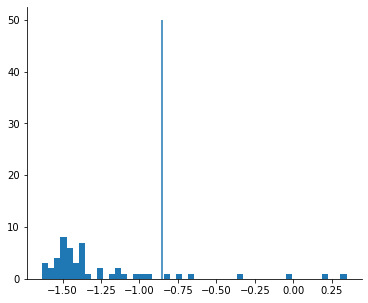

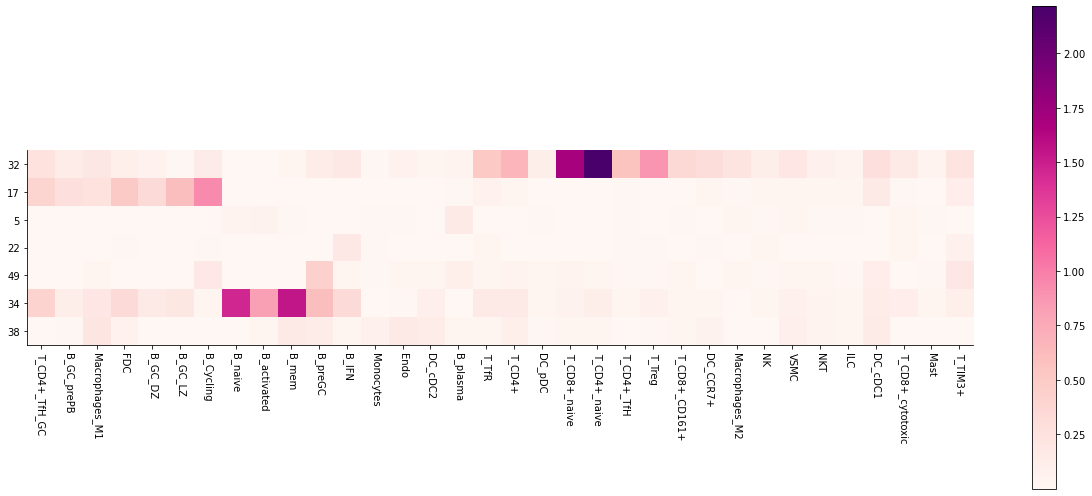

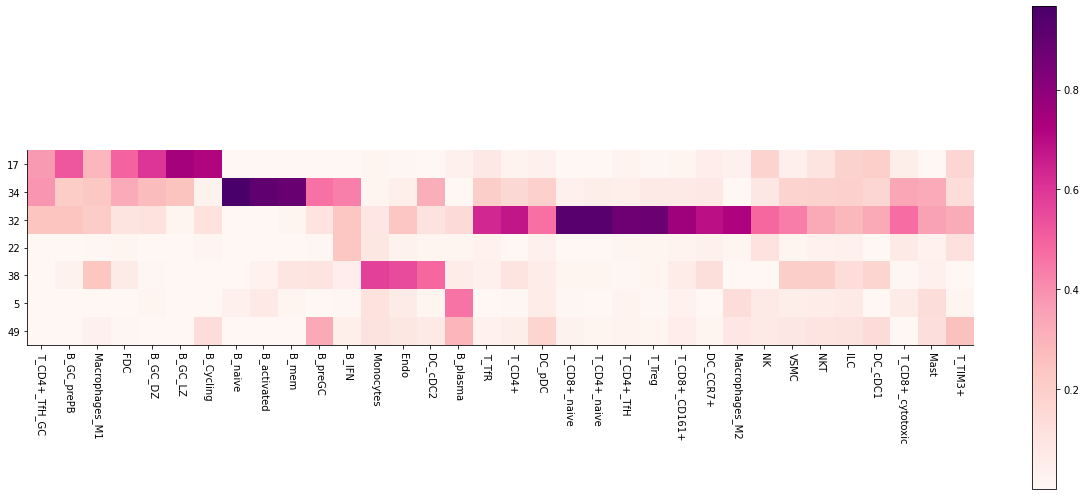

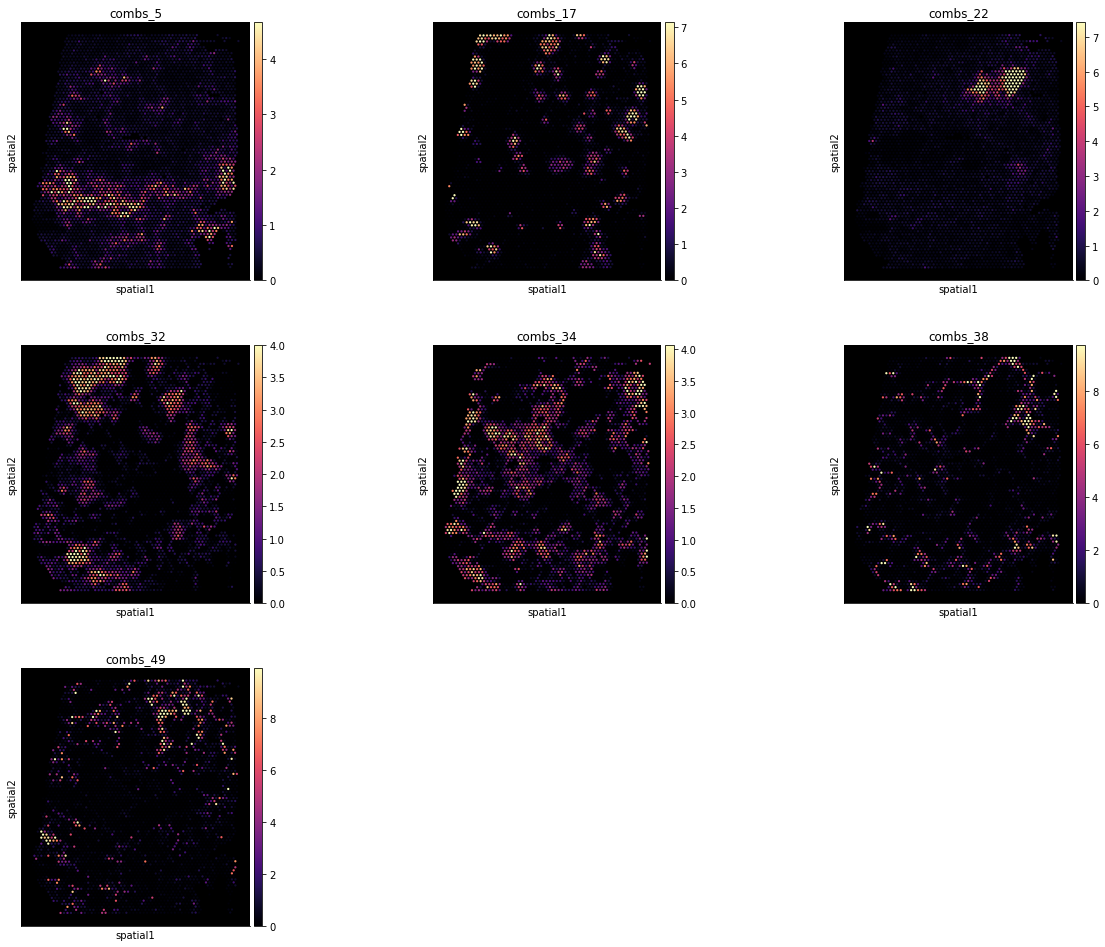

In [3]:
from cell2location.plt.plot_heatmap import clustermap
comb2fact_df = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['x_fr_group2fact'],
                            columns=adata_vis.uns['mod']['factor_names'])

rcParams["figure.figsize"] = [6, 5]
rcParams["axes.facecolor"] = "white"
plt.hist(np.log10(comb2fact_df.max(1)), bins=50);
thresh = 0.14
plt.vlines(np.log10(thresh), 0, 50);
fact_filt = comb2fact_df.max(1) > thresh

comb2fact_df = comb2fact_df.loc[fact_filt.values, :]

clustermap(comb2fact_df, figure_size=(17, 7))

comb2fact_df_prop = (comb2fact_df / comb2fact_df.sum(0))
clustermap(comb2fact_df_prop, figure_size=(17, 7))

n_combs = adata_vis.uns['mod']['post_sample_means']['z_sr_groups_factors'].shape[1]
combs_factors = pd.DataFrame(adata_vis.uns['mod']['post_sample_means']['z_sr_groups_factors'],
                             columns=[f'combs_{i}' for i in range(n_combs)],
                             index=adata_vis.uns['mod']['obs_names'])
combs_factors = combs_factors.loc[:, fact_filt.values]
adata_vis.obs[combs_factors.columns] = combs_factors


s = 'V1_Human_Lymph_Node'
rcParams["axes.facecolor"] = "black"
sc.pl.spatial(adata_vis[adata_vis.obs['sample'].isin([s]),:], cmap='magma',
              color=combs_factors.columns, # limit size in this notebook
              library_id=f'{s}',
              ncols=3, 
              size=1, img_key='hires', 
              alpha_img=0,
              vmin=0, vmax='p99.0'
             )

### Running factorisation to identify groups of co-located cell types / tissue compartments <a class="anchor" id="factorisation"></a>

In [7]:
from cell2location import run_colocation
adata_vis.uns['mod']['post_sample_q05']['spot_factors'] = adata_vis.uns['mod']['post_sample_q05']['w_sf'].copy()
adata_vis.uns['mod']['fact_names'] = adata_vis.uns['mod']['factor_names'].copy()
res_dict, sp_data = run_colocation(
                   adata_vis, #model_name='CoLocatedCombination_sklearnNMF',
                   verbose=False, return_all=True,
    
                   train_args={'n_fact': [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 28, 30], 'n_iter': 20000,
                    'sample_name_col': 'sample',
                    'mode': 'normal', 'n_type': 'restart', 'n_restarts': 2},
    
                   model_kwargs={'init': 'random', 'random_state': 0, 'nmf_kwd_args': {'tol': 0.0001}},
    
                   posterior_args={},
                   export_args={'path': f'{scvi_run_path}CoLocatedComb/',
                                'run_name_suffix': 'tol0.0001'})

### Analysis name: CoLocatedGroupsSklearnNMF_8combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_9combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_10combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_13combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_14combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_15combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_16combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_17combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_18combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_19combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_20combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_22combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_25combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_28combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_30combinations_4035locations_34factorstol0.0001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
... storing 'sample' as categorical


In [8]:
from cell2location import run_colocation
adata_vis.uns['mod']['post_sample_q05']['spot_factors'] = adata_vis.uns['mod']['post_sample_q05']['w_sf'].copy()
adata_vis.uns['mod']['fact_names'] = adata_vis.uns['mod']['factor_names'].copy()
res_dict, sp_data = run_colocation(
                   adata_vis, #model_name='CoLocatedCombination_sklearnNMF',
                   verbose=False, return_all=True,
    
                   train_args={'n_fact': [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 25, 28, 30], 'n_iter': 20000,
                    'sample_name_col': 'sample',
                    'mode': 'normal', 'n_type': 'restart', 'n_restarts': 2},
    
                   model_kwargs={'init': 'random', 'random_state': 0, 'nmf_kwd_args': {'tol': 0.00001}},
    
                   posterior_args={},
                   export_args={'path': f'{scvi_run_path}CoLocatedComb/',
                                'run_name_suffix': 'tol0.00001'})

### Analysis name: CoLocatedGroupsSklearnNMF_8combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_9combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_10combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_11combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_12combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_13combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_14combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_15combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_16combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_17combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_18combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_19combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_20combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_22combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_25combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_28combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical


### Analysis name: CoLocatedGroupsSklearnNMF_30combinations_4035locations_34factorstol0.00001


/nfs/team283/vk7/software/miniconda3farm5/envs/pyro160/lib/python3.7/site-packages/anndata/_core/anndata.py:1208: ImplicitModificationWarning: Initializing view as actual.
Trying to set attribute `.obs` of view, copying.
... storing 'sample' as categorical
... storing 'sample' as categorical


### Running factorisation including the composition of neighbouring spots <a class="anchor" id="factorisation_with_neighbours"></a>